In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from matplotlib.pyplot import figure

In [2]:
Basket=["TSLA","GOOG","AMZN"]

data=pd.DataFrame()
for i in Basket:
    d=pd.read_csv("C:/Users/Jihed/Desktop/EPT/3eme année/Financial ingeneering/Tiguene/Projet/"+i+".csv")
    data[i]=d['Close']
    L=d.Date

data.index=L
data

,TSLA,GOOG,AMZN
Date,,,
2022-01-03,399.926666,145.074493,170.404495
2022-01-04,383.196655,144.416504,167.522003
2022-01-05,362.706665,137.653503,164.356995
2022-01-06,354.899994,137.550995,163.253998
2022-01-07,342.320007,137.004501,162.554001
...,...,...,...
2022-12-23,123.150002,89.809998,85.250000
2022-12-27,109.099998,87.930000,83.040001
2022-12-28,112.709999,86.459999,81.820000


# Basket of Call Option

## 1- Naive Monte Carlo Method for Basket Call Option without correlation

In [3]:
def GeneratePathsGBMABM(NoOfPaths,NoOfSteps,T,r,sigma,S_0):  # generate paths function  
    
    # Fixing random seed
    np.random.seed(1)
        
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    S = np.zeros([NoOfPaths, NoOfSteps+1])
    time = np.zeros([NoOfSteps+1])
        
    X[:,0] = np.log(S_0)  # first colonne will be initial value 
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
            
        X[:,i+1] = X[:,i] + (r - 0.5 * sigma **2 ) * dt + sigma * np.power(dt, 0.5)*Z[:,i]
        time[i+1] = time[i] +dt

    #Compute exponent of ABM
    S = np.exp(X)  
    
    paths = {"time":time,"S":S}
    return paths

Value of the Basket sans prendre en compte la corrélation à t0 = 17.356904684069335


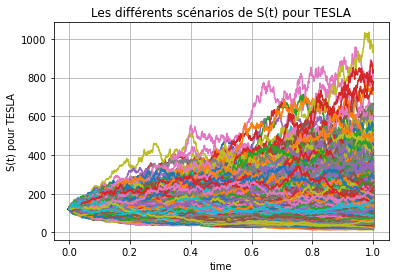

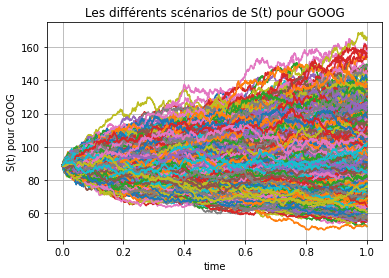

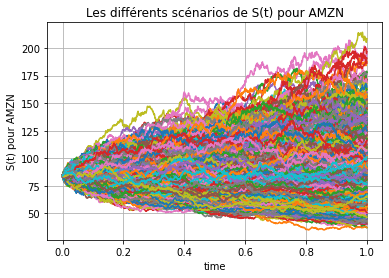

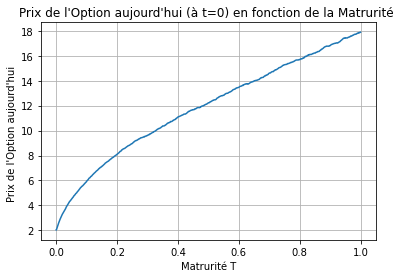

In [4]:
def DigitalPayoffValuation(a,b,c,T,r,payoff):  # calculate discounted value of the payoff 
    # S is a vector of Monte Carlo samples at T
    return np.exp(-r*T) * np.mean(payoff(a,b,c))


def mainCalculation():  # set parametres function
    NoOfPaths = 5000
    NoOfSteps = 1000
    T = 1
    r = 0.03
    K=100
    
    sigma_Tesla = np.std(data.TSLA)/100
    sigma_GOOG = np.std(data.GOOG)/100
    sigma_AMZN = np.std(data.AMZN)/100
    
    S_0_Tesla = data.TSLA[-1]
    S_0_GOOG = data.GOOG[-1]
    S_0_AMZN = data.AMZN[-1]
    
    
    Paths_Tesla = GeneratePathsGBMABM(NoOfPaths,NoOfSteps,T,r,sigma_Tesla,S_0_Tesla)
    Paths_GOOG = GeneratePathsGBMABM(NoOfPaths,NoOfSteps,T,r,sigma_GOOG,S_0_GOOG)
    Paths_AMZN = GeneratePathsGBMABM(NoOfPaths,NoOfSteps,T,r,sigma_AMZN,S_0_AMZN)

     
    S_Tesla = Paths_Tesla["S"]
    S_Tesla_T = S_Tesla[:,-1]
     
    S_GOOG = Paths_GOOG["S"]
    S_GOOG_T = S_GOOG[:,-1]
     
    S_AMZN = Paths_AMZN["S"]
    S_AMZN_T = S_AMZN[:,-1]
    
    ti = Paths_Tesla["time"]
    
    payoff = lambda a,b,c: np.maximum(4/10*a+1/10*b+5/10*c -K,0.0)
    
    val_t0 = DigitalPayoffValuation(S_Tesla_T,S_AMZN_T,S_GOOG_T,T,r,payoff)
    print("Value of the Basket sans prendre en compte la corrélation à t0 = {0}".format(val_t0))
    
  
    
    plt.figure(1)
    plt.plot(ti, np.transpose(S_Tesla))   
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("S(t) pour TESLA")
    plt.title("Les différents scénarios de S(t) pour TESLA")
    
    plt.figure(2)
    plt.plot(ti, np.transpose(S_GOOG))   
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("S(t) pour GOOG")
    plt.title("Les différents scénarios de S(t) pour GOOG")
    
    plt.figure(3)
    plt.plot(ti, np.transpose(S_AMZN))   
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("S(t) pour AMZN")
    plt.title("Les différents scénarios de S(t) pour AMZN")
    
    plt.figure(4)
    plt.plot(ti, np.mean(payoff(S_Tesla,S_AMZN,S_GOOG),0))
    plt.grid()
    plt.xlabel("Matrurité T")
    plt.ylabel("Prix de l'Option aujourd'hui ")
    plt.title("Prix de l'Option aujourd'hui (à t=0) en fonction de la Matrurité ")
    
mainCalculation()

## 2- Naive Monte Carlo Method for Basket Call Option with correlation

In [5]:
corr=data.corr()
corr

,TSLA,GOOG,AMZN
TSLA,1.000000,0.827953,0.913995
GOOG,0.827953,1.000000,0.926569
AMZN,0.913995,0.926569,1.000000


In [6]:
chol = np.linalg.cholesky(corr)
chol

array([[1.        , 0.        , 0.        ],
       [0.82795314, 0.56079728, 0.        ],
       [0.91399497, 0.3028259 , 0.27001792]])

In [7]:
def GeneratePathsGBMABM_C(NoOfPaths,NoOfSteps,T,r,sigma0,sigma1,sigma2,S_0,S_1,S_2,chol):  # generate paths function  
    
    # Fixing random seed
    np.random.seed(1)
    
    # chaque actif posséde son matrice aléatoire 
    # Z0 correspond à l'actif 0 (Tesla)  : C'est le term aléatoire
    # Z1 correspont à l'actif 1 (GOOG)
    # Z2 correspont à l'actif 2 (AMZN)
    
    Z0 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    
    X0 = np.zeros([NoOfPaths, NoOfSteps+1])
    S0 = np.zeros([NoOfPaths, NoOfSteps+1])
    
    X1 = np.zeros([NoOfPaths, NoOfSteps+1])
    S1 = np.zeros([NoOfPaths, NoOfSteps+1])
    
    X2 = np.zeros([NoOfPaths, NoOfSteps+1])
    S2 = np.zeros([NoOfPaths, NoOfSteps+1])
    

        
    X0[:,0] = np.log(S_0)  
    X1[:,0] = np.log(S_1)
    X2[:,0] = np.log(S_2)
    
    dt = T / float(NoOfSteps)
    
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1 
        if NoOfPaths > 1:
            Z0[:,i] = (Z0[:,i] - np.mean(Z0[:,i])) / np.std(Z0[:,i])
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
            Z2[:,i] = (Z2[:,i] - np.mean(Z2[:,i])) / np.std(Z2[:,i])
        
        Z1[:,i]=chol[1,0]*Z0[:,i]+chol[1,1]*Z1[:,i]
        Z2[:,i]=chol[2,0]*Z0[:,i]+chol[2,1]*Z1[:,i]+chol[2,2]*Z1[:,i]
        
        X0[:,i+1] = X0[:,i] + (r - 0.5 * sigma0 **2 ) * dt + sigma0 * np.power(dt, 0.5)* Z0[:,i]    
        X1[:,i+1] = X1[:,i] + (r - 0.5 * sigma1 **2 ) * dt + sigma1 * np.power(dt, 0.5)* Z1[:,i]  
        X2[:,i+1] = X2[:,i] + (r - 0.5 * sigma2 **2 ) * dt + sigma2 * np.power(dt, 0.5)* Z2[:,i]  

        
    #Compute exponent of ABM
    S0 = np.exp(X0)  
    S1 = np.exp(X1) 
    S2 = np.exp(X2) 
    
    paths = {"S0":S0,"S1":S1,"S2":S2}   
    
    return paths


In [8]:
def DigitalPayoffValuation(a,b,c,T,r,payoff):  # calculate discounted value of the payoff 
    # S is a vector of Monte Carlo samples at T
    return np.exp(-r*T) * np.mean(payoff(a,b,c))


def mainCalculation():  # set parametres function
    
    NoOfPaths = 5000
    NoOfSteps = 1000
    T = 1
    r = 0.03
    K=100
    
    sigma_Tesla = np.std(data.TSLA)/100
    sigma_GOOG = np.std(data.GOOG)/100
    sigma_AMZN = np.std(data.AMZN)/100
    
    S_0_Tesla = data.TSLA[-1:]
    S_0_GOOG = data.GOOG[-1:]
    S_0_AMZN = data.AMZN[-1:]

    # 0,1,2 içi comme index refere pour  
    Paths = GeneratePathsGBMABM_C(NoOfPaths,NoOfSteps,T,r,sigma_Tesla,sigma_GOOG,sigma_AMZN,S_0_Tesla,S_0_GOOG,S_0_AMZN,chol)

     
    S_Tesla = Paths["S0"]
    S_Tesla_T = S_Tesla[:,-1]  
     
    S_GOOG = Paths["S1"]
    S_GOOG_T = S_GOOG[:,-1]
     
    S_AMZN = Paths["S2"]
    S_AMZN_T = S_AMZN[:,-1]
    
    
    payoff = lambda a,b,c: np.maximum(4/10*a+1/10*b+5/10*c -K,0.0)
    
    val_t0 = DigitalPayoffValuation(S_Tesla_T,S_AMZN_T,S_GOOG_T,T,r,payoff)
    print('Value of the Basket avec corrélation "using Cholesky" à t0 = {0}'.format(val_t0))
    

    
mainCalculation()

Value of the Basket avec corrélation "using Cholesky" à t0 = 17.472064475101675


# Asian Option

## 3- Average Asian Option Without Control Variates Method

In [9]:
def PayoffValuation(S,T,r,payoff):
    # S is a vector of Monte Carlo samples at T
    return np.exp(-r*T) * np.mean(payoff(S))

def mainCalculation():
    NoOfPaths = 5000
    NoOfSteps = 250
   
    S0    =  data.TSLA[-1:]
    r     = 0.03
    T    = 1
    sigma = np.std(data.TSLA)/100
     
    paths = GeneratePathsGBMABM(NoOfPaths,NoOfSteps,T,r,sigma,S0)
    S_paths= paths["S"]
    S_T = S_paths[:,-1]
    
    
    # Payoff setting    
    K  = 100.0
    
    # Payoff specification
    payoff = lambda S: np.maximum(S-K,0.0)  
 
    
    A_T= np.mean(S_paths,1)  

   
    valAsian_t0 = PayoffValuation(A_T,T,r,payoff)
        
    print("Value of the Asian option at t0 ={0}".format(valAsian_t0))
    print('variance of the PayOff = {0}'.format(np.var(A_T)))
    
mainCalculation()

Value of the Asian option at t0 =29.59419431288036
variance of the PayOff = 1992.3758430156536


## 4- Applied Control Variates Method for Average Asian Option 

In [10]:
# pip install py_vollib
# pip install -U llvmlite==0.32.1
from py_vollib.black_scholes import black_scholes

-As we have a coefficient of correlation 0.8621089856093459 between the Average Asian Option and the European Call Option. This value is good enough to see perfect result with this Control Variates Method.

-The parametre c used in the Control Variates Method is equal to : 0.46675715106496557 . This value of c give us the minimum     value of variance. 

-Value of the Asian option at t0 = 29.447273314078444
-variance of the PayOff (the Controlled Random Variable) = 423.98374915297376


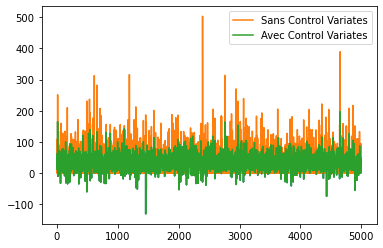

In [11]:
def mainCalculation():
    NoOfPaths = 5000
    NoOfSteps = 250
   
    S0    = data.TSLA[-1:]
    r     = 0.03
    T    = 1
    sigma = np.std(data.TSLA)/100  #0.57

    
    paths = GeneratePathsGBMABM(NoOfPaths,NoOfSteps,T,r,sigma,S0)
    S_paths= paths["S"]
    S_T = S_paths[:,-1]
    
    # Payoff setting    
    K  = 100.0
    
    # Payoff specification
    payoff = lambda S: np.maximum(S-K,0.0)  
        

    u=black_scholes('c', S0, K, T, r, sigma) # u must be Know 
#    u1=np.mean(payoff(S_T))

    A_T= np.mean(S_paths,1)
    
    c=np.cov(A_T,S_T)[0,1]/np.var(S_T)
    
    print("-As we have a coefficient of correlation",np.cov(A_T,S_T)[0,1]/(((np.var(S_T))**0.5) * ((np.var(A_T))**0.5)),"\
between the Average Asian Option and the European Call Option. This value is good enough to see perfect result with this \
Control Variates Method.\n")
    
    print("-The parametre c used in the Control Variates Method is equal to :",c,". This value of c give us the minimum \
    value of variance. \n")
    
    AA=payoff(A_T)*np.exp(-r*T)-c*(payoff(S_T)*np.exp(-r*T)-u)
    valAsian_t0=np.mean(AA)
    plt.plot(AA)
    print("-Value of the Asian option at t0 = {0}".format(valAsian_t0))   
    print('-variance of the PayOff (the Controlled Random Variable) = {0}'.format(np.var(AA)))
    
    #Plot
    plt.plot(payoff(A_T)*np.exp(-r*T),label="Sans Control Variates")
    plt.plot(AA,label="Avec Control Variates")
    plt.legend()

    
mainCalculation()

# Antithetic Variates

valAsian_t0_avec 29.466286825374617
valAsian_t0_sans 29.498905584517193
-variance of the PayOff without Antithetic Variates = 1531.6816300216317
-variance of the PayOff with Antithetic Variates = 669.295619980386


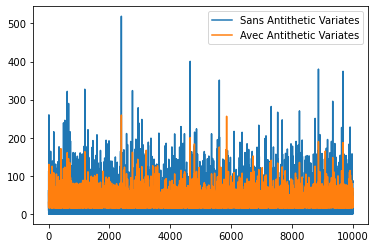

In [12]:
def GeneratePathsGBMABM2(NoOfPaths,NoOfSteps,T,r,sigma,S_0):  # generate paths function  
    np.random.seed(1)
    # Fixing random seed
        
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])

    X = np.zeros([NoOfPaths, NoOfSteps+1])
    S = np.zeros([NoOfPaths, NoOfSteps+1])
    
    X2 = np.zeros([NoOfPaths, NoOfSteps+1])
    S2 = np.zeros([NoOfPaths, NoOfSteps+1])
    
    time = np.zeros([NoOfSteps+1])
        
    X[:,0] = np.log(S_0)  
    X2[:,0] = np.log(S_0)
    
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
            Z2[:,i] = (Z2[:,i] - np.mean(Z2[:,i])) / np.std(Z2[:,i])
            
        X[:,i+1] = X[:,i] + (r - 0.5 * sigma **2 ) * dt + sigma * np.power(dt, 0.5)*Z[:,i]
        X2[:,i+1] = X2[:,i] + (r - 0.5 * sigma **2 ) * dt - sigma * np.power(dt, 0.5)*Z[:,i]
        
        time[i+1] = time[i] +dt

        
    #Compute exponent of ABM
    S = np.exp(X)  
    S2 = np.exp(X2)
    paths = {"time":time,"S":S,"S2":S2}
    return paths




def mainCalculation():
    NoOfPaths = 10000
    NoOfSteps = 250
   
    S0    = data.TSLA[-1:]
    r     = 0.03
    T    = 1
    sigma = np.std(data.TSLA)/100  #0.57

    
    paths = GeneratePathsGBMABM2(NoOfPaths,NoOfSteps,T,r,sigma,S0)
    
    
    S_paths= paths["S"]

    
    S_paths2= paths["S2"]
    
    # Payoff setting    
    K  = 100.0
    
    # Payoff specification
    payoff = lambda S: np.maximum(S-K,0.0)  
        



    A_T= np.mean(S_paths,1)
    A_T2= np.mean(S_paths2,1)
    
    
    
    
    AA=payoff(A_T)+payoff(A_T2)
    
    valAsian_t0_avec=0.5*np.mean(AA)*np.exp(-r*T)
    
    valAsian_t0_sans=np.mean(payoff(A_T)*np.exp(-r*T))
    
    
    print("valAsian_t0_avec",valAsian_t0_avec )

    print("valAsian_t0_sans", valAsian_t0_sans)

    
    print('-variance of the PayOff without Antithetic Variates = {0}'.format(np.var(payoff(A_T))))   
    
    print('-variance of the PayOff with Antithetic Variates = {0}'.format(0.5*np.var(AA)))
    
    #Plot
    plt.plot(payoff(A_T),label="Sans Antithetic Variates")
    plt.plot(0.5*AA,label="Avec Antithetic Variates")
    plt.legend()

    
mainCalculation()